<a href="https://colab.research.google.com/github/spetti/SMURF/blob/main/examples/sw_in_tensorflow_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

In [ ]:
def sw_simple(batch=True, unroll=2):
  '''smith-waterman (local alignment) with no gap, no temp, no mask'''

  # rotate to vectorize
  def sw_rotate(x, mask=None):
    # solution from jake vanderplas (thanks!)
    a,b = x.shape
    ar,br = jnp.arange(a)[::-1,None], jnp.arange(b)[None,:]
    i,j = (br-ar)+(a-1),(ar+br)//2
    n,m = (a+b-1),(a+b)//2
    zero = jnp.zeros([n,m])
    if mask is None: mask = 1.0
    output = {"x":zero.at[i,j].set(x),
              "m":zero.at[i,j].set(mask),
              "o":(jnp.arange(n)+a%2)%2}
    prev = (jnp.zeros(m), jnp.zeros(m))
    return output,prev,(i,j)

  # comute scoring (hij) matrix
  def sw_sco(x):
    def _cond(cond, true, false):
      return cond*true + (1-cond)*false
    def _step(prev, sm):      
      h2,h1 = prev  # previous two rows of scoring (hij) mtx
      h1_T = _cond(sm["o"],jnp.pad(h1[:-1],[1,0]),jnp.pad(h1[1:],[0,1]))
      h0 = sm["m"] * jax.nn.logsumexp(jnp.stack([h2+sm["x"], h1, h1_T]),0)
      return (h1,h0),h0
    sm,prev,idx = sw_rotate(x)
    hij = jax.lax.scan(_step, prev, sm, unroll=unroll)[-1][idx]
    return hij.max()

  # traceback (aka backprop) to get alignment
  traceback = jax.grad(sw_sco)

  # add batch dimension
  if batch: return jax.vmap(traceback)
  else: return traceback

In [ ]:
sw_fn = jax.jit(sw_simple())

In [ ]:
path_jax = sw_fn(jnp.ones((128,100,100)))

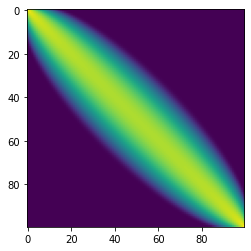

In [ ]:
plt.imshow(jnp.log(path_jax[0] + 1e-8))

#RUNNING IN TENSORFLOW

In [ ]:
from jax.experimental.jax2tf import jax2tf
import tensorflow as tf

In [ ]:
@tf.function(jit_compile=True)
def sw_fn_tf(x):
  return jax2tf.convert(sw_simple())(x)

In [ ]:
path_tf = sw_fn_tf(tf.ones((128,100,100))).numpy()

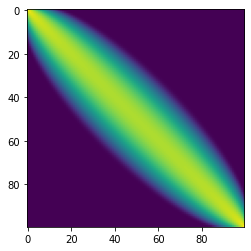

In [ ]:
plt.imshow(np.log(path_tf + 1e-8)[0])

# RUNNING IN PYTORCH

In [ ]:
import torch
import torch.utils.dlpack
import jax
import jax.dlpack

# A generic mechanism for turning a JAX function into a PyTorch function.

def j2t(x_jax):
  x_torch = torch.utils.dlpack.from_dlpack(jax.dlpack.to_dlpack(x_jax))
  return x_torch

def t2j(x_torch):
  x_torch = x_torch.contiguous()  # https://github.com/google/jax/issues/8082
  x_jax = jax.dlpack.from_dlpack(torch.utils.dlpack.to_dlpack(x_torch))
  return x_jax

def jax2torch(fun):

  class JaxFun(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
      y_, ctx.fun_vjp = jax.vjp(fun, t2j(x))
      return j2t(y_)

    @staticmethod
    def backward(ctx, grad_y):
      grad_x_, = ctx.fun_vjp(t2j(grad_y))
      return j2t(grad_x_),

  return JaxFun.apply

In [ ]:
sw_fn_torch = jax2torch(jax.jit(sw_simple()))

In [ ]:
path_torch = sw_fn_torch(torch.ones((128,100,100)).cuda())

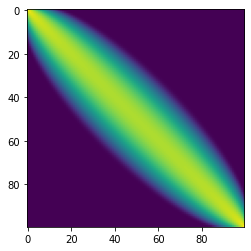

In [ ]:
plt.imshow(torch.log(path_torch + 1e-8)[0].detach().cpu())

#SPEED TEST (forward pass only)

In [ ]:
import time

In [ ]:
for mode in ["jax","tensorflow","pytorch"]:
  t = time.time()
  for _ in range(1000):
    if mode == "jax":
      _ = sw_fn(jnp.ones((128,100,100)))

    if mode == "tensorflow":
      _ = sw_fn_tf(tf.ones((128,100,100)))
    
    if mode == "pytorch":
      _ = sw_fn_torch(torch.ones((128,100,100)).cuda())
      
  t = time.time() - t
  print(mode, t)

jax 10.129317998886108
tensorflow 10.521260738372803
pytorch 17.33734393119812
